In [1]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random, math, time

c:\Users\Ishika\anaconda3\envs\ait\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load the dataset

Dataset Source: https://huggingface.co/datasets/Helsinki-NLP/opus-100/viewer/en-ne

I have choose dataset to translate english to nepali. so i have the dataset from huggingface. The dataset name is opus100 and it has multiple language and 'en-ne' helps to specify the language pair: English (en) to Nepali (ne).

In [4]:
from datasets import load_dataset

dataset = load_dataset("opus100",'en-ne')

In [5]:
dataset

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 406381
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [6]:
dataset['train'][15]

{'translation': {'en': 'New file, project and project components.',
  'ne': 'नयाँ योजना, परियोजना र परियोजना अवयव'}}

## EDA - simple investigation

In [7]:
# Set random seed for reproducibility
from numpy.random import default_rng
rng = default_rng(seed=SEED)

# Select a random sample of 200,000 indices from the training set
select_index = set(rng.choice(len(dataset['train']), size=150000, replace=False))

# Filter training dataset to retain only selected indices
dataset['train'] = dataset['train'].filter(lambda _, index: index in select_index, with_indices=True)# Define the function to extract both languages
def extract_languages(data):
    return {
        'ne': data['translation']['ne'],  # Extract Nepali translation
        'en': data['translation']['en']   # Extract English translation
    }

# Apply the function to the dataset and remove the 'translation' column
dataset = dataset.map(extract_languages, remove_columns=['translation'])


dataset

DatasetDict({
    test: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['ne', 'en'],
        num_rows: 150000
    })
    validation: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
})

In [8]:
#let's take a look at one example of train
test_1 = next(iter(dataset['train']))
test_1

{'ne': 'डेटाबेसStencils', 'en': 'Database'}

Random seed is done using 'default_rng' so that every time code is run, we get the same result. As we have large number of dataset for train. so i have reduced its size to 150000by randomly selecting it and filter the dataset to retain only  the example at the selected index.

## Preprocessing 

### Tokenization

Note: the models must first be downloaded using the following on the command line:

    -python3 -m spacy download en_core_web_sm
First, since we have two languages, let's create some constants to represent that. Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

Nepali tokenizer need to be installed. "pip install nepalitokenizers" 

In [9]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [10]:
from torchtext.data.utils import get_tokenizer
SRC_LANGUAGE = 'en'
TRG_LANGUAGE= 'ne'

In [11]:
from torchtext.data.utils import get_tokenizer
from nepalitokenizers import WordPiece

## IMporting of tokenizer libraries
## using WordPiece as Nepal tokenizer
token_transform["en"] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform["ne"] = WordPiece()

In [12]:
#example of tokenization of the english part
print("Sentence: ", dataset['train']['ne'][10])
#example of tokenization of the nepali part
print("Tokenization: ", token_transform['ne'].encode(dataset['train']['ne'][10]).tokens)

Sentence:  मास्क फाइल विस्तार:
Tokenization:  ['[CLS]', 'मास्क', 'फाइल', 'विस्तार', ':', '[SEP]']


In [13]:
# Define a function to tokenize the data for a given language
def tokenize_the_data(data, lang):
    try:
        # Tokenize the data using the specified language tokenizer
        return {lang: token_transform[lang](data[lang].lower())}
    except:
        # If an exception occurs, use WordPiece tokenizer for Nepali language
        return {lang: token_transform[lang].encode(data[lang].lower()).tokens}

# Map the tokenization function to tokenize the source language data and remove the original column
tokenized_dataset = dataset.map(tokenize_the_data, remove_columns=[SRC_LANGUAGE], fn_kwargs={'lang': SRC_LANGUAGE})

# Map the tokenization function to tokenize the target language data and remove the original column
tokenized_dataset = tokenized_dataset.map(tokenize_the_data, remove_columns=[TRG_LANGUAGE], fn_kwargs={'lang': TRG_LANGUAGE})

Map: 100%|██████████| 2000/2000 [00:00<00:00, 4795.48 examples/s]


In [14]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [15]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(tokenized_dataset['train'][ln], 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [159]:
# saveing vocab
torch.save(vocab_transform, 'model/vocab')

In [16]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[236, 20, 11, 0, 11]

In [17]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[236]

'here'

In [18]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [19]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [20]:
#check unique vocabularies
len(mapping)

15464


For the preparation of dataset for translation model requires different steps which inludes text normalization, tokenization, and word segmentation. All the necessary libary and tools requires was installed. 

The Nepali language is tokenized using word pieces using the Nepali Tokenizers library (WordPiece tokenizer). Managing the unique characteristics of the Nepali language, such as its script and word segmentation, requires this library. 

The English language is tokenized using Spacy (spacy tokenizer). It guarantees accurate and efficient tokenization and is a strong library for tasks involving natural language processing. 

As for Special symbols <unk>, <pad>,<sos>,<eso> with index 0,1,2,3 repectively was defined and each symbol has itw own meaning. <unk> is used to represent unknown, <pad> is used to ensure all sequence of same length,<sos> is for start of sentence and <eso> is for end of sentence.To normalized the token to integer build_vocab_from_iterator has been used.

## Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [21]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            try:
                # Apply the transformation to the text input
                txt_input = transform(txt_input)
            except:
                # If an exception occurs (e.g., if the transform is an encoding operation), catch it
                txt_input = transform.encode(txt_input).tokens
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [22]:
batch_size = 64

train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [23]:
for en, _, ne in train_loader:
    break

In [24]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Nepali shape: ", ne.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 3])
Nepali shape:  torch.Size([64, 5])


## Design the model

### Encoder Layer

In [35]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant,device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout,attn_variant, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [36]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout,attn_variant, device, max_length = 100):
        super().__init__()
        self.device = device
        self.attn_variant = attn_variant
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant,device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
            

### Mutli Head Attention Layer

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

In [37]:
class AdditiveAttention(nn.Module):
    def __init__(self, head_dim):
        super(AdditiveAttention, self).__init__()
        
        # Linear layers for additive attention
        self.Wa = nn.Linear(head_dim, head_dim)
        self.Ua = nn.Linear(head_dim, head_dim)
        self.V = nn.Linear(head_dim, 1)

    def forward(self, query, keys):
        # Add singleton dimensions for broadcasting
        query = query.unsqueeze(3)
        keys = keys.unsqueeze(2)

        # Apply additive attention mechanism
        features = torch.tanh(self.Wa(query) + self.Ua(keys))
        
        # Calculate attention scores
        scores = self.V(features).squeeze(-1)
        
        return scores

In [38]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, attn_variant, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        
        # Initialize parameters
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.attn_variant = attn_variant

        # Linear transformations for query, key, value, and output
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Scale factor for attention scores
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        # Initialize additive attention mechanism
        self.additive_attention = AdditiveAttention(self.head_dim)

    def forward(self, query, key, value, mask=None):
        # Shapes: query = [batch size, query len, hid dim], key = [batch size, key len, hid dim], value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        # Apply linear transformations to query, key, and value
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Reshape and permute for multi-head attention
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Calculate attention scores based on the selected attention variant
        if self.attn_variant == "multiplicative":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        elif self.attn_variant == "general":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))

        elif self.attn_variant == "additive":
            energy = self.additive_attention(Q, K)

        else:
            raise Exception("Incorrect value for attention variant. Must be one of the following: multiplicative, additive, general")

        # Mask attention scores if a mask is provided
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Apply softmax to obtain attention weights
        attention = torch.softmax(energy, dim=-1)

        # Perform weighted sum using attention weights
        x = torch.matmul(attention, V)

        # Transpose and reshape to the original shape
        x = x.transpose(-1, -2)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)

        # Apply linear transformation for the final output
        x = self.fc_o(x)

        return x, attention

### Position-wise Feedforward Layer

In [39]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

In [45]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant,device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant,device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout,attn_variant, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [46]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout,attn_variant, device,max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant,device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [57]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        self.params = {'encoder': encoder, 'decoder': decoder,
                       'src_pad_idx': src_pad_idx, 'trg_pad_idx': trg_pad_idx}
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

##  Training

In [58]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [59]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1
## Passing of attention variant
attn_variant = 'additive'

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(15464, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (additive_attention): AdditiveAttention(
            (Wa): Linear(in_features=32, out_features=32, bias=True)
            (Ua): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          

In [60]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

3958784
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
2455040
 25600
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
1310

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [61]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [62]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [63]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [64]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [65]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


### Three Model Training

In [77]:
import gc

input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
## low learning rate in order to increase model complexity
lr = 0.0000001
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

num_epochs = 5
clip       = 1
## Attention variant is passed as a list
for attn_variant in ['general', 'multiplicative', 'additive']:

    train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    valid_loader = DataLoader(dataset['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    train_loader_length = len(list(iter(train_loader)))
    val_loader_length   = len(list(iter(valid_loader)))
    test_loader_length  = len(list(iter(test_loader)))

    enc = Encoder(input_dim,
                  hid_dim,
                  enc_layers,
                  enc_heads,
                  enc_pf_dim,
                  enc_dropout,
                  attn_variant,
                  device)

    dec = Decoder(output_dim,
                  hid_dim,
                  dec_layers,
                  dec_heads,
                  dec_pf_dim,
                  enc_dropout,
                  attn_variant,
                  device)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    #training hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

    save_path = f"model/{attn_variant}_{model.__class__.__name__}.pt"
   

    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    print(f'\n===== {attn_variant} =====')

    for epoch in range(num_epochs):

        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)


        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path)
            # torch.save(model.state_dict(), save_path)
            # torch.save([model.params, model.state_dict()], save_path)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        #lower perplexity is better

    # empty gpu cache to clear memory
    del enc
    del dec
    del model
    torch.cuda.empty_cache()
    gc.collect()


===== general =====
Epoch: 01 | Time: 1m 56s
	Train Loss: 8.575 | Train PPL: 5296.934
	 Val. Loss: 7.565 |  Val. PPL: 1929.185
Epoch: 02 | Time: 1m 53s
	Train Loss: 7.527 | Train PPL: 1857.990
	 Val. Loss: 6.568 |  Val. PPL: 711.665
Epoch: 03 | Time: 2m 29s
	Train Loss: 6.689 | Train PPL: 803.676
	 Val. Loss: 5.908 |  Val. PPL: 368.093
Epoch: 04 | Time: 1m 59s
	Train Loss: 6.098 | Train PPL: 445.003
	 Val. Loss: 5.444 |  Val. PPL: 231.428
Epoch: 05 | Time: 1m 58s
	Train Loss: 5.665 | Train PPL: 288.497
	 Val. Loss: 5.101 |  Val. PPL: 164.140

===== multiplicative =====
Epoch: 01 | Time: 2m 2s
	Train Loss: 8.347 | Train PPL: 4215.520
	 Val. Loss: 7.082 |  Val. PPL: 1189.837
Epoch: 02 | Time: 1m 57s
	Train Loss: 7.108 | Train PPL: 1221.803
	 Val. Loss: 6.192 |  Val. PPL: 488.746
Epoch: 03 | Time: 1m 58s
	Train Loss: 6.397 | Train PPL: 600.029
	 Val. Loss: 5.666 |  Val. PPL: 288.762
Epoch: 04 | Time: 1m 54s
	Train Loss: 5.919 | Train PPL: 372.071
	 Val. Loss: 5.313 |  Val. PPL: 202.997
E

| Attentions   |  Training Loss| Traning PPL   | Validation Loss|  Validation PPL   |
|--------|------------------|--------|------------------|--------|
| General Attention | 5.665         | 288.497  | 5.101         | 164.140  | 
|  Multiplicative Attention| 5.567        | 261.776  | 5.051         |156.174  | 
| Additive Attention | 5.547     | 256.393 | 5.031          | 153.126  | 




In [78]:
# Create DataLoader for training data with batching and shuffling
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

# Create DataLoader for validation data with batching (no shuffling during validation)
valid_loader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Create DataLoader for test data with batching (no shuffling during testing)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Calculate the number of batches in each DataLoader
train_loader_length = len(list(iter(train_loader)))
val_loader_length = len(list(iter(valid_loader)))
test_loader_length = len(list(iter(test_loader)))

In [79]:

import gc
import time
import math

input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])


batch_size = 32
lr = 0.0000001
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX

train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))


num_epochs = 5
clip       = 1

## Evaluation and Veification

### General Model Training

In [80]:
## Working with general attention
attn_variant = "general"

encode = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

decode = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(encode, decode, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model = Seq2SeqTransformer(encode, decode, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_losses_general = []
valid_losses_general = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0  # Variable to store the total time taken for all epochs

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses_general.append(train_loss)
    valid_losses_general.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses_general
final_train_loss = train_losses_general[-1]
final_valid_loss = valid_losses_general[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

# Calculate time taken for the traning
average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))




##### general #####
Epoch: 01 | Time: 2m 1s
	Train Loss: 8.604 | Train PPL: 5454.322
	Val. Loss: 7.564 | Val. PPL: 1928.445
Epoch: 02 | Time: 1m 54s
	Train Loss: 7.607 | Train PPL: 2011.588
	Val. Loss: 6.641 | Val. PPL: 765.975
Epoch: 03 | Time: 1m 57s
	Train Loss: 6.754 | Train PPL: 857.079
	Val. Loss: 5.971 | Val. PPL: 392.062
Epoch: 04 | Time: 1m 53s
	Train Loss: 6.142 | Train PPL: 465.159
	Val. Loss: 5.495 | Val. PPL: 243.473
Epoch: 05 | Time: 1m 58s
	Train Loss: 5.693 | Train PPL: 296.691
	Val. Loss: 5.131 | Val. PPL: 169.117
Final Training Loss: 5.693 | Final Validation Loss: 5.131 | Final Train PPL 296.691 | Final Valid PPL 169.117 | Average Time per epoch (117.00393528938294,) | Overall time 0.02495817732282059


In [ ]:
## Working with multiplicative attention
print(f'Final Training Loss: {final_train_loss:.3f}')
print (f'Final Validation Loss: {final_valid_loss:.3f}')
print(f'Final Train PPL {final_train_ppl:.3f}')
print(f'Final Valid PPL {final_valid_ppl:.3f}')
print(f'Average Time per epoch {average_time_per_epoch}')
print(f'Overall time {overall_average_time}')

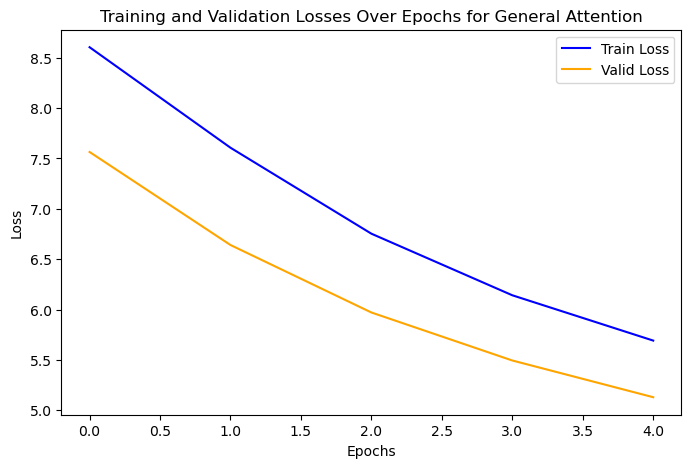

In [81]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses_general, label='Train Loss', color='blue')
ax.plot(valid_losses_general, label='Valid Loss', color='orange')

# Add title, labels, and legend
plt.title('Training and Validation Losses Over Epochs for General Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [82]:
# Path to the saved model file
save_path = 'model/general_Seq2SeqTransformer.pt'

# Load the model parameters and state
params, state = torch.load(save_path)

# Initialize the Seq2SeqTransformer model using the loaded parameters and move it to the specified device
model = Seq2SeqTransformer(**params, device=device).to(device)

# Load the model state
model.load_state_dict(state)

# Evaluate the model on the test data and calculate the test loss
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

# Print the test loss and test perplexity
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.101 | Test PPL: 164.140 |


### Training with Multiplicative Model

In [83]:
attn_variant = "multiplicative"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model_multiplicative = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model_multiplicative.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model_multiplicative = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)


best_valid_loss = float('inf')
train_losses_multiplicative = []
valid_losses_multiplicative = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0  # Variable to store the total time taken for all epochs

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model_multiplicative, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_multiplicative, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses_multiplicative.append(train_loss)
    valid_losses_multiplicative.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses_multiplicative
final_train_loss = train_losses_multiplicative[-1]
final_valid_loss = valid_losses_multiplicative[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

# Calculate time taken for the traning
average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f}')
print(f'Final Validation Loss: {final_valid_loss:.3f}')
print(f'Final Train PPL {final_train_ppl:.3f}')
print(f'Final Valid PPL {final_valid_ppl:.3f}')
print(f'Average Time per epoch {average_time_per_epoch}')
print(f'Overall time {overall_average_time}')


##### multiplicative #####
Epoch: 01 | Time: 1m 53s
	Train Loss: 8.367 | Train PPL: 4302.787
	Val. Loss: 7.143 | Val. PPL: 1264.666
Epoch: 02 | Time: 2m 46s
	Train Loss: 7.129 | Train PPL: 1247.481
	Val. Loss: 6.212 | Val. PPL: 498.722
Epoch: 03 | Time: 1m 51s
	Train Loss: 6.394 | Train PPL: 598.006
	Val. Loss: 5.651 | Val. PPL: 284.616
Epoch: 04 | Time: 2m 2s
	Train Loss: 5.896 | Train PPL: 363.534
	Val. Loss: 5.277 | Val. PPL: 195.709
Epoch: 05 | Time: 1m 58s
	Train Loss: 5.529 | Train PPL: 251.853
	Val. Loss: 4.996 | Val. PPL: 147.887
Final Training Loss: 5.529
Final Validation Loss: 4.996
Final Train PPL 251.853
Final Valid PPL 147.887
Average Time per epoch (126.4155065536499,)
Overall time 0.026965765049839996


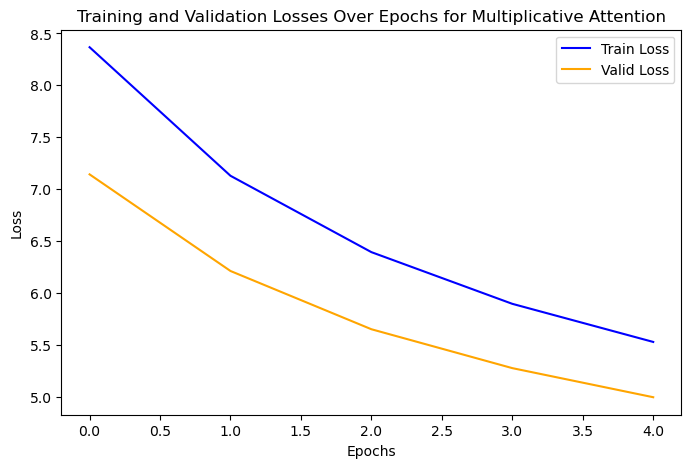

In [84]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses_multiplicative, label='Train Loss', color='blue')
ax.plot(valid_losses_multiplicative, label='Valid Loss', color='orange')

# Add title, labels, and legend
plt.title('Training and Validation Losses Over Epochs for Multiplicative Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [85]:
save_path = 'model/multiplicative_Seq2SeqTransformer.pt'
params, state = torch.load(save_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.051 | Test PPL: 156.174 |


### Training with Additive Model

In [86]:
attn_variant = "additive"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_losses = []
valid_losses = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0  # Variable to store the total time taken for all epochs

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses
final_train_loss = train_losses[-1]
final_valid_loss = valid_losses[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

# Calculate time taken for the traning
average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f}') 
print(f'Final Validation Loss: {final_valid_loss:.3f} ')
print(f'Final Train PPL {final_train_ppl:.3f}')
print(f'Final Valid PPL {final_valid_ppl:.3f}') 
print(f'Average Time per epoch {average_time_per_epoch}')
print(f'Overall time {overall_average_time}')


##### additive #####
Epoch: 01 | Time: 2m 11s
	Train Loss: 8.190 | Train PPL: 3605.244
	Val. Loss: 6.938 | Val. PPL: 1030.900
Epoch: 02 | Time: 2m 16s
	Train Loss: 6.975 | Train PPL: 1069.282
	Val. Loss: 6.082 | Val. PPL: 437.714
Epoch: 03 | Time: 2m 7s
	Train Loss: 6.304 | Train PPL: 546.765
	Val. Loss: 5.579 | Val. PPL: 264.732
Epoch: 04 | Time: 2m 16s
	Train Loss: 5.845 | Train PPL: 345.528
	Val. Loss: 5.231 | Val. PPL: 187.007
Epoch: 05 | Time: 4m 20s
	Train Loss: 5.498 | Train PPL: 244.292
	Val. Loss: 4.967 | Val. PPL: 143.629
Final Training Loss: 5.498
Final Validation Loss: 4.967 
Final Train PPL 244.292
Final Valid PPL 143.629
Average Time per epoch (158.45446319580077,)
Overall time 0.03380001348033293


In [88]:
save_path = 'model/additive_Seq2SeqTransformer.pt'
params, state = torch.load(save_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.031 | Test PPL: 153.126 |


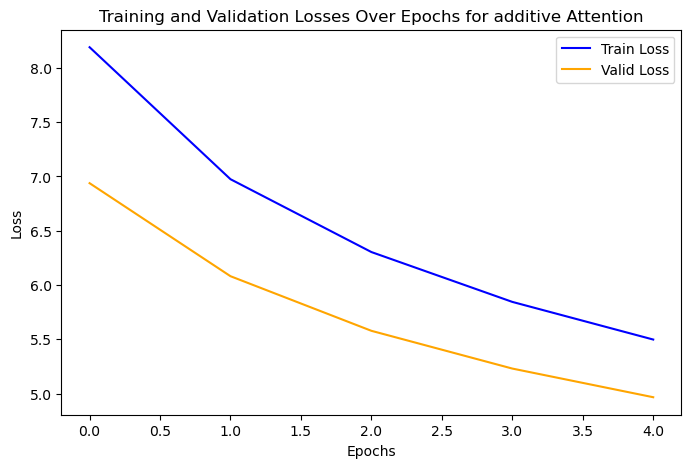

In [89]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses, label='Train Loss', color='blue')
ax.plot(valid_losses, label='Valid Loss', color='orange')

# Add title, labels, and legend
plt.title('Training and Validation Losses Over Epochs for additive Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

## Testing

In [96]:
dataset['test'][15]['en']

'Shift Righ_t and Move'

In [97]:
dataset['test'][15]['ne']

'दायाँ शीफ्ट गर्नुहोस् र सार्नुहोस्'

In [98]:
src_text = text_transform[SRC_LANGUAGE](dataset['test'][15]['en']).to(device)

# Print or use the source text as needed
print(src_text)

tensor([ 2,  0,  0, 26,  0,  3], device='cuda:0')


In [99]:
# Get the source text from the test dataset at index 1 in Nepali
trg_text = text_transform[TRG_LANGUAGE](dataset['test'][15]['ne']).to(device)
trg_text

tensor([   2,    4,  395, 6452, 1139,    7,   35,  178,   24,    9,    5,    3],
       device='cuda:0')

In [100]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1
trg_text = trg_text.reshape(1, -1)  #because batch_size is 1

In [101]:
src_text.shape, trg_text.shape

(torch.Size([1, 6]), torch.Size([1, 12]))

In [102]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

### Testing Additive Model

In [103]:
import torch
import time

# Load the model
load_path = 'model/additive_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

# Record the start time
start_time = time.time()

# Set the model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    output, attentions_additive = model(src_text, trg_text)  # Turn off teacher forcing

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Time taken for inference: {elapsed_time} seconds")

# Calculate the model size without using os
with open(load_path, 'rb') as f:
    model_size = len(f.read()) / (1024 * 1024)  # Size in megabytes

# Print the model size
print(f"Model size: {model_size:.2f} MB")

Time taken for inference: 0.016971826553344727 seconds
Model size: 49.35 MB


In [104]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 12, 9590])

In [105]:
output = output.squeeze(0)

In [106]:
output.shape

torch.Size([12, 9590])

In [107]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([11, 9590])

In [108]:
output_max = output.argmax(1) #returns max indices

In [109]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([10, 9590])

In [110]:
output_max = output.argmax(1) #returns max indices

In [111]:

mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [112]:
output_additive = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_additive.append(token_str)

[CLS]
[CLS]
[SEP]
<eos>
तीव्र
[SEP]
कार्टुन
सम्भाव्यता
<eos>
[SEP]


### Testing Multiplicative Model

In [113]:
import torch
import time

# Load the model
load_path = 'model/general_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

# Set the model to evaluation mode
model.eval()

# Record the start time
start_time = time.time()

# Perform inference
with torch.no_grad():
    output, attentions_multiplicative = model(src_text, trg_text)  # Turn off teacher forcing

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Time taken for inference: {elapsed_time} seconds")

# Calculate the model size without using os
with open(load_path, 'rb') as f:
    model_size = len(f.read()) / (1024 * 1024)  # Size in megabytes

# Print the model size
print(f"Model size: {model_size:.2f} MB")

Time taken for inference: 0.004985809326171875 seconds
Model size: 49.35 MB


In [114]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 12, 9590])

In [115]:
output = output.squeeze(0)

In [116]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([11, 9590])

In [117]:
output_max = output.argmax(1) #returns max indices

In [118]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [119]:
output_additive = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_additive.append(token_str)

<eos>
##डिङ
गरे
en
<eos>
[CLS]
<eos>
[CLS]
##ya
[SEP]
[CLS]


### Testing General Model

In [120]:
import torch
import time

# Load the model
load_path = 'model/general_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

# Set the model to evaluation mode
model.eval()

# Record the start time
start_time = time.time()

# Perform inference
with torch.no_grad():
    output, attentions_general = model(src_text, trg_text)  # Turn off teacher forcing

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Time taken for inference: {elapsed_time} seconds")

# Calculate the model size without using os
with open(load_path, 'rb') as f:
    model_size = len(f.read()) / (1024 * 1024)  # Size in megabytes

# Print the model size
print(f"Model size: {model_size:.2f} MB")

Time taken for inference: 0.0049860477447509766 seconds
Model size: 49.35 MB


In [121]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 12, 9590])

In [122]:
output = output.squeeze(0)

In [123]:
output.shape

torch.Size([12, 9590])

In [124]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([11, 9590])

In [125]:
output_max = output.argmax(1) #returns max indices

In [126]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [127]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [128]:
output_additive = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_additive.append(token_str)

<eos>
##डिङ
गरे
en
<eos>
[CLS]
<eos>
[CLS]
##ya
[SEP]
[CLS]


## Attention

In [136]:
attentions_additive.shape, attentions_general.shape, attentions_multiplicative.shape

(torch.Size([1, 8, 12, 6]),
 torch.Size([1, 8, 12, 6]),
 torch.Size([1, 8, 12, 6]))

In [152]:
# Extract attention matrices for the additive, general, and multiplicative attention mechanisms
attention_additive = attentions_additive[0, 0, :, :]
attention_general = attentions_general[0, 0, :, :]
attention_multiplicative = attentions_general[0, 0, :, :]

# Print or use the shapes of the attention matrices as needed
print(attention_additive.shape, attentions_general.shape, attention_multiplicative.shape)

torch.Size([12, 6]) torch.Size([1, 8, 12, 6]) torch.Size([12, 6])


In [153]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](dataset['test'][1]['en']) + ['<eos>']

# Print or use the source tokens as needed
print(src_tokens)

['<sos>', 'Treize', '<eos>']


In [154]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 '<eos>',
 '##डिङ',
 'गरे',
 'en',
 '<eos>',
 '[CLS]',
 '<eos>',
 '[CLS]',
 '##ya',
 '[SEP]',
 '[CLS]']

In [155]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, title):
  
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.set_title(title)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    plt.close()

C:\Users\Ishika\AppData\Local\Temp\ipykernel_120992\2027380819.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Ishika\AppData\Local\Temp\ipykernel_120992\2027380819.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
c:\Users\Ishika\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Ishika\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Ishika\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2367 (\N{DEVANA

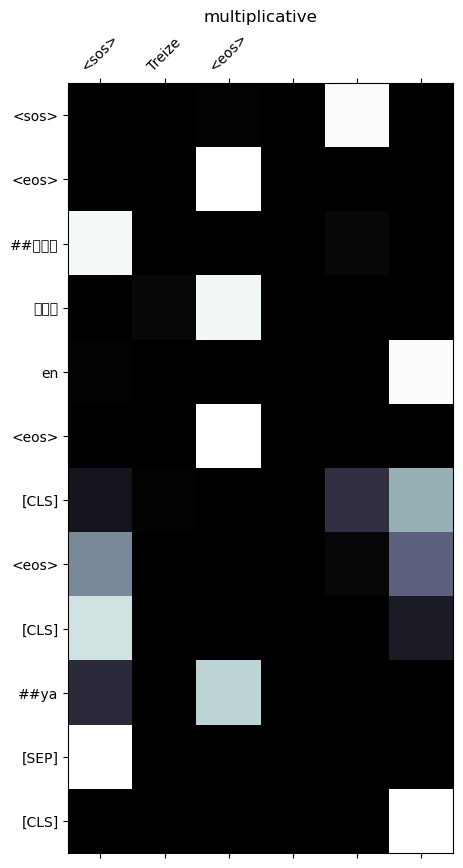

In [156]:
display_attention(src_tokens, trg_tokens, attention_multiplicative, "multiplicative")

C:\Users\Ishika\AppData\Local\Temp\ipykernel_120992\2027380819.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Ishika\AppData\Local\Temp\ipykernel_120992\2027380819.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
c:\Users\Ishika\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Ishika\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Ishika\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2367 (\N{DEVANA

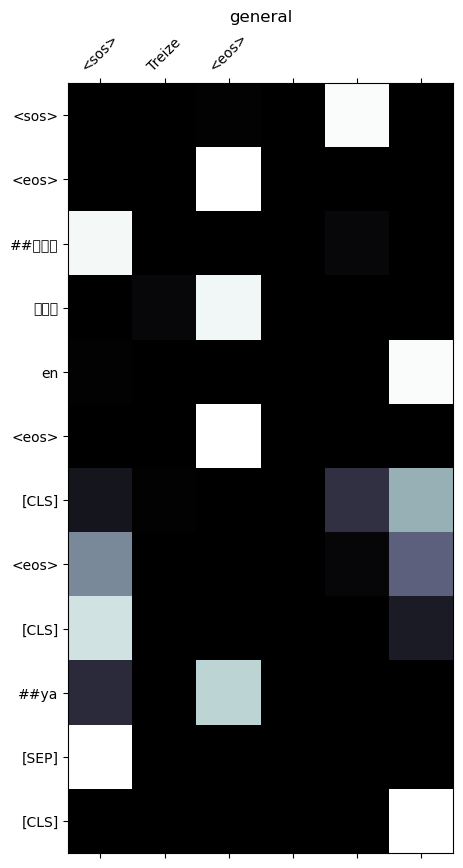

In [157]:
display_attention(src_tokens, trg_tokens, attention_general, "general")

C:\Users\Ishika\AppData\Local\Temp\ipykernel_120992\2027380819.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Ishika\AppData\Local\Temp\ipykernel_120992\2027380819.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
c:\Users\Ishika\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Ishika\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Ishika\anaconda3\envs\ait\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2367 (\N{DEVANA

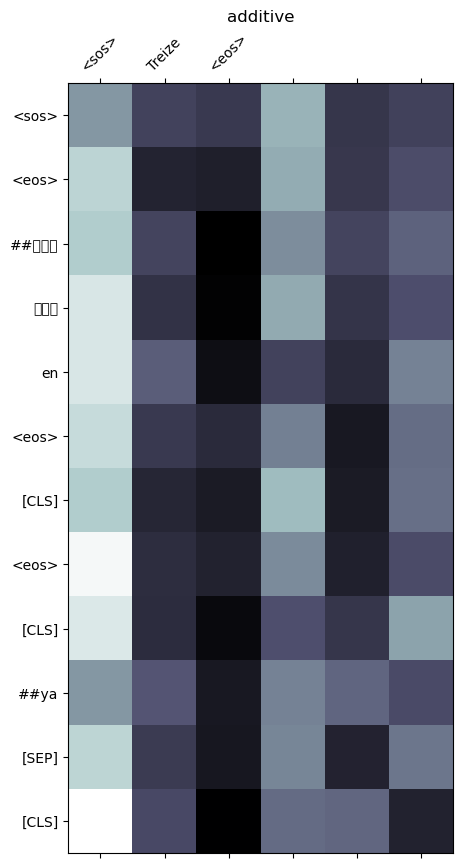

In [158]:
display_attention(src_tokens, trg_tokens, attention_additive, "additive")

## Web Application Development

For web application UI, I have used Dash. In file name model_definitions.py, model is integrated. As for UI design,implementation of model  and  vocabulary is loaded using pickle ii at app.py. The translation process involves tokenizing the input English text, converting it into tensor format, and passing it through the encoder-decoder architecture of the transformer model. The decoder generates the translated Nepali text token by token until an end-of-sequence (EOS) token is produced or the maximum length is reached.The input text is translated, and the result is displayed below. The interface also features the Nepali flag image for visual appeal. The app runs on a local server and is designed to be responsive and easy to use.


